In [1]:
%load_ext autoreload
%autoreload 2

In [91]:
import torch
from torch import nn
from lib.modules import (
    read_and_window_nursing_session,
    read_nursing_session,
    read_nursing_labels,
    optimization_loop,
    evaluate_loop,
    predict_and_plot_pretty_session
)
from lib.utils import (
    plot_and_save_cm,
    plot_and_save_losses,
    summary,
    get_bouts_smoothed
)
from lib.models import ResEncoderClassifier, ResEncoderClassifierAve, ResNetClassifier
from lib.data.datasets import AccRawDataset, AccAndLabelsDataset
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
nursing_raw_dir = Path("/home/musa/datasets/nursingv1")
nursing_label_dir = Path("/home/musa/datasets/eating_labels")
WINSIZE = 505
DEVICE = 'cuda:1'
autoencoder_dir = Path('dev/5_resnetautoencoder/5_autoencoder-resnet/')
encoderclass_dir = Path('dev/5_resnetautoencoder/encoderclass-conv/5_encoderclass-resnet_1-pretrained-frozen/')

# Data Processing

In [4]:
all_sessions = set(range(71))
not_labeled = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 34, 70}
reserved = {15, 43, 45, 51, 55}
sessions = list(all_sessions - not_labeled - reserved)
np.random.seed(10)
train_sessions, test_sessions = train_test_split(sessions, test_size=0.25)

In [12]:
Xtr = torch.Tensor()
Xte = torch.Tensor()
ytr = torch.Tensor()
yte = torch.Tensor()

from lib.modules import pad_for_windowing
winsize = 101

for session_idx in sessions:
    df = read_nursing_session(session_idx, nursing_raw_dir)
    labels = read_nursing_labels(session_idx, nursing_label_dir)
    X = torch.Tensor(df.values)
    y = torch.zeros(len(X), 1)
    y[labels['start']:labels['end']] = 1

    if session_idx in train_sessions:
        Xtr = torch.cat((Xtr, X))
        ytr = torch.cat((ytr, y))
    else:
        Xte = torch.cat((Xte, X))
        yte = torch.cat((yte, y))

tr = AccAndLabelsDataset(pad_for_windowing(Xtr, winsize), ytr, winsize)
te = AccAndLabelsDataset(pad_for_windowing(Xte, winsize), yte, winsize)

In [24]:
print(len(tr) / 100 / 60 / 60 + len(te) / 100 / 60 / 60)
print(len(tr) / 100 / 60 / 60)
print(len(te) / 100 / 60 / 60)

23.755555555555553
17.316666666666666
6.438888888888888


In [5]:
# train_sessions = [25, 67, 42, 50, 22, 61, 33, 21, 16, 18]
# test_sessions = [58, 62]

# Xs = []
# ys = []

# for session_idx in train_sessions:
#     X,y = read_and_window_nursing_session(session_idx, WINSIZE, nursing_raw_dir, nursing_label_dir)

#     Xs.append(X)
#     ys.append(y)

# Xtr = torch.cat(Xs)
# ytr = torch.cat(ys)

# Xs = []
# ys = []

# for session_idx in test_sessions:
#     X,y = read_and_window_nursing_session(session_idx, WINSIZE, nursing_raw_dir, nursing_label_dir)

#     Xs.append(X)
#     ys.append(y)

# Xte = torch.cat(Xs)
# yte = torch.cat(ys)

In [ ]:
nursing_trainloader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
nursing_testloader = DataLoader(TensorDataset(Xte,yte), batch_size=64)

torch.save(nursing_trainloader, 'pytorch_datasets/nursing_trainloader_11-25-23.pt')
torch.save(nursing_testloader, 'pytorch_datasets/nursing_testloader_11-25-23.pt')

# Train

In [11]:
nursing_trainloader = torch.load('pytorch_datasets/nursing_trainloader_11-25-23.pt')
nursing_testloader = torch.load('pytorch_datasets/nursing_testloader_11-25-23.pt')

In [ ]:
# nursing_trainloader = torch.load('pytorch_datasets/nursing_trainloader-test.pt')
# nursing_testloader = torch.load('pytorch_datasets/nursing_testloader-test.pt')

In [12]:
model = ResEncoderClassifier(WINSIZE, weights_file=autoencoder_dir / 'best_model.pt', freeze=True).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

Model is loading pretrained encoder
Model is freezing encoder


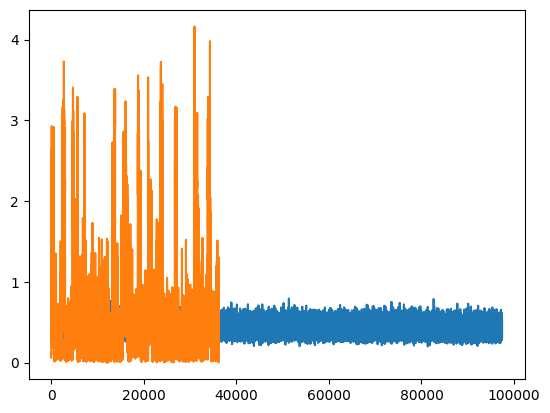

In [20]:
import matplotlib.pyplot as plt

train_loss = []
model.train()
for X,y in nursing_trainloader:
    X,y = X.to(DEVICE), y.to(DEVICE)
    logits = model(X)
    loss = criterion(logits, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

test_loss = []
model.eval()
for X,y in nursing_testloader:
    X,y = X.to(DEVICE), y.to(DEVICE)
    logits = model(X)
    loss = criterion(logits, y)
    
    test_loss.append(loss.item())

plt.plot(train_loss)
plt.plot(test_loss)


In [25]:
import plotly.express as px

fig = px.line(x=np.arange(len(train_loss)), y=train_loss, title='Train Loss')
# fig.add_scatter(x=np.arange(len(test_loss)), y=test_loss, mode='lines', name='Test Loss')
fig.show(renderer='browser')

In [7]:
optimization_loop(model, nursing_trainloader, nursing_testloader, criterion, optimizer, 2, DEVICE, patience=20, min_delta=0.001, outdir=encoderclass_dir)

: Epoch 1: Train Loss: 0.46324: Dev Loss: 0.46501: 100%|██████████| 2/2 [10:32<00:00, 316.17s/it]


: 

# Evaluate


In [47]:
WINSIZE = 101
DEVICE = 'cuda:1'

In [4]:
nursing_trainloader = torch.load('pytorch_datasets/nursing_trainloader_11-25-23.pt')
nursing_testloader = torch.load('pytorch_datasets/nursing_testloader_11-25-23.pt')

In [ ]:
model = ResEncoderClassifierAve(WINSIZE, weights_file=autoencoder_dir / 'best_model.pt', freeze=True).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model.load_state_dict(torch.load(Path('dev/5_resnetautoencoder/encoder_class-avg_100hl/1-pretrained-frozen/') / 'best_model.pt'))

In [49]:
model = ResNetClassifier(WINSIZE, in_channels=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [51]:
model.load_state_dict(torch.load(Path('dev/resnet/best_model.pt')))
# model.load_state_dict(torch.load(Path('dev/resnet/model/30.pt')))

<All keys matched successfully>

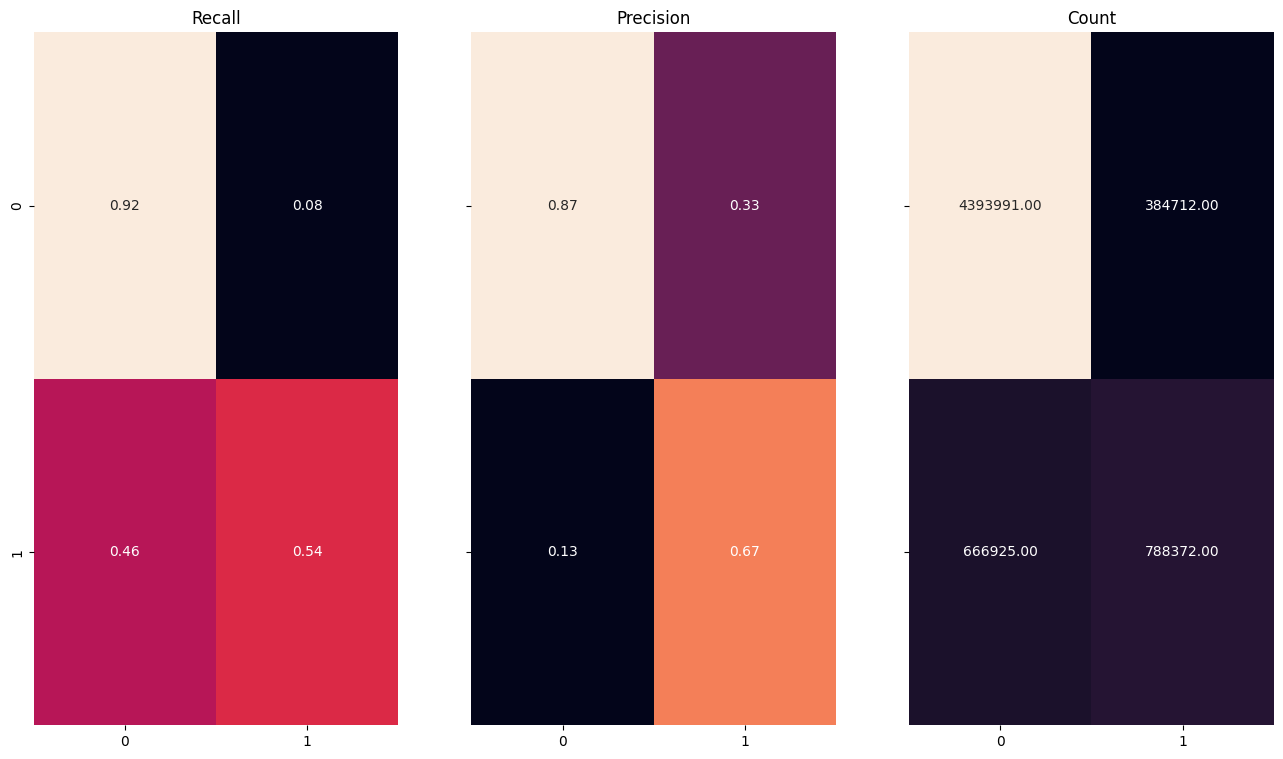

Metric        Value
---------  --------
loss       0.379466
precision  0.672051
recall     0.541726
f1         0.599892


In [15]:
ys,metrics = evaluate_loop(model, criterion, nursing_trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

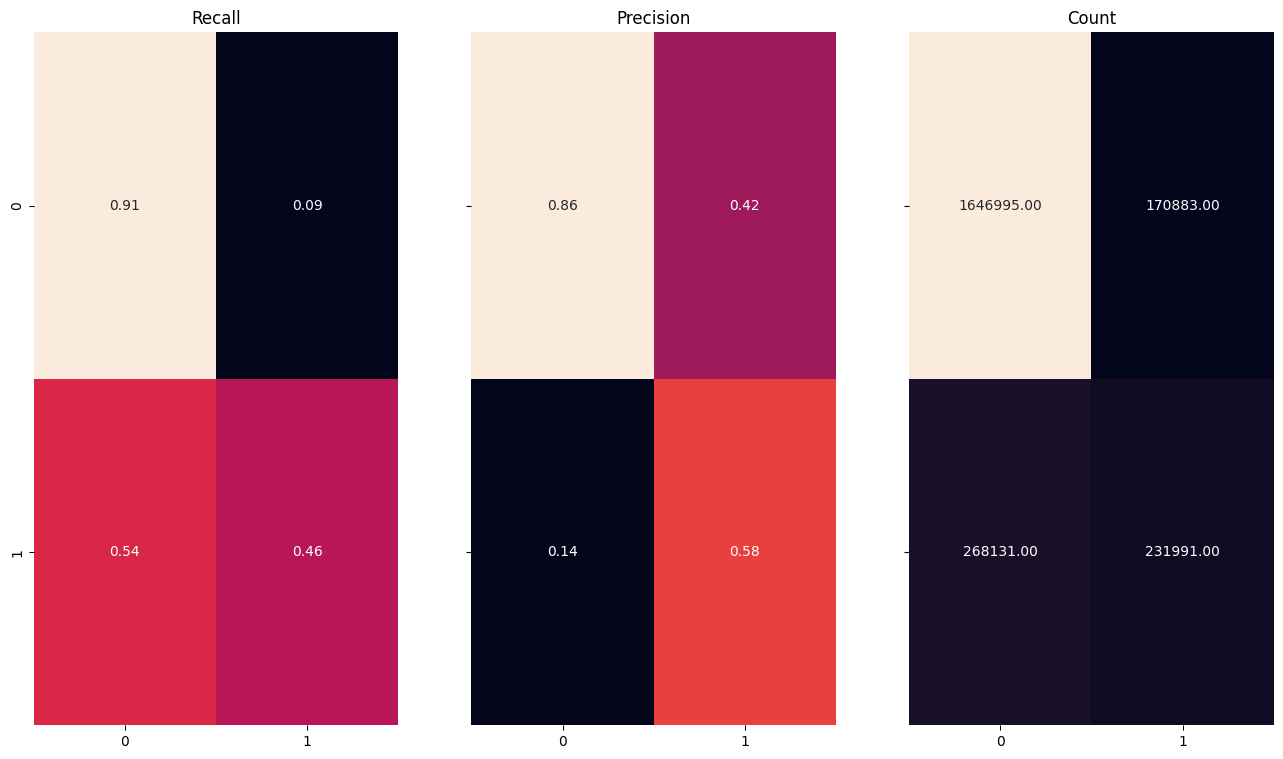

Metric        Value
---------  --------
loss       0.434015
precision  0.57584
recall     0.463869
f1         0.513825


In [52]:
ys,metrics = evaluate_loop(model, criterion, nursing_testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

In [48]:
test_session = test_sessions[0]

predict_and_plot_pretty_session(
    session_idx=test_session,
    dim_factor=5,
    datapath=nursing_raw_dir,
    labelpath=nursing_label_dir,
    winsize=WINSIZE,
    model=model,
    criterion=criterion,
    batch_size=64,
    device=DEVICE,
    smooth=True
)

Metric        Value
---------  --------
loss       0.291395
precision  0.837496
recall     0.701595
f1         0.763546


# Cheating Evaluation


In [9]:
WINSIZE = 101
DEVICE = 'cuda:1'

In [7]:
# load all nursing, shuffle them all
all_sessions = set(range(71))
not_labeled = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 34, 70}
reserved = {15, 43, 45, 51, 55}
sessions = list(all_sessions - not_labeled - reserved)
np.random.seed(10)
train_sessions, test_sessions = train_test_split(sessions, test_size=0.25)

In [12]:
Xs = torch.Tensor()
ys = torch.Tensor()

for session_idx in sessions:
    X,y = read_and_window_nursing_session(session_idx, WINSIZE, nursing_raw_dir, nursing_label_dir)

    Xs = torch.cat((Xs, X))
    ys = torch.cat((ys, y))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [73]:
Xtr, Xte, ytr, yte = train_test_split(Xs, ys, test_size=0.25)
cheating_trainloader = DataLoader(TensorDataset(Xtr, ytr))
cheating_testloader = DataLoader(TensorDataset(Xte, yte))

In [74]:
model = ResNetClassifier(WINSIZE, 3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [75]:
optimization_loop(
    model, 
    cheating_trainloader, 
    cheating_testloader, 
    criterion, 
    optimizer, 
    100, 
    DEVICE, 
    patience=30,
    min_delta=0.0001,
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
ys,metrics = evaluate_loop(model, criterion, cheating_trainloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)

ValueError: Target size (torch.Size([1])) must be the same as input size (torch.Size([1, 1]))

In [ ]:
ys,metrics = evaluate_loop(model, criterion, cheating_testloader, DEVICE)
plot_and_save_cm(ys['true'], ys['pred'])
summary(metrics)